<a href="https://colab.research.google.com/github/amugod119/ML-Prediction-of-Hydrogen-storage-properties-of-Alloy-from-SEM-Descriptors-using-SEM-images/blob/main/Hydrogen_Storage_Code_for_ML_part.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**MORPHOLOGICAL DESCRIPTORS FROM SEM IMAGES**



In [ ]:
pip install opencv-python scikit-image numpy scipy

**IMPORTING LIBRARIES THAT WILL BE NEEDED FOR THE WHOLE PROJECT**

In [ ]:
# Keeping imports organized here so we know exactly what's available.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression # Added LinearRegression
from sklearn.tree import DecisionTreeRegressor # Added DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
from IPython.display import display # Import display for debugging
import ast  # This is for parsing string lists
import shap
from sklearn.inspection import PartialDependenceDisplay
from sklearn.impute import SimpleImputer
import xgboost as xgb
import math # Import math for ceil

# Setting a random seed to make sure our results are reproducible
np.random.seed(42)

TABLE_1 WITH ALLOY MATERIALS WITH CORREPONSING PROPERTIES COLLECTED FROM LITERATURES

In [ ]:
Table_1 = pd.read_csv("Table 1 recollected - Table 1_update references.csv")
Table_1

,SEM_ID,Material System,SEM image,Synthesis Method,H2 Uptake(wt%),Hydrogenation temp(K),Hydrogenation pressure (bar),Reference,Source
0,SEM_001,MgMg₂NiLaH,NaN,H-induced decomposition,7.19,598.0,30,\cite{ding2022} DOI: https://doi.org/10.1016/j...,NaN
1,SEM_002,MgMg₂NiLaH,NaN,H-induced decomposition,5.89,448.0,10,\cite{ding2022} DOI: https://doi.org/10.1016/j...,NaN
2,SEM_003,Ti₁₉Hf₄V₄₀Mn₃₅Cr₂,NaN,-Arc-melting,3.55,293.0,30,"\cite{halpren2023} DOI: N/A (Thesis, no DOI pr...",2023 Hydrogen storage from alloys properties.pdf
3,SEM_004,Ti₁₉Hf₄V₄₀Mn₃₅Cr₂,NaN,-Arc-melting,3.41,293.0,30,"\cite{halpren2023} DOI: N/A (Thesis, no DOI pr...",2023 Hydrogen storage from alloys properties.pdf
4,SEM_005,Ti₁₉Hf₄V₄₀Mn₃₅Cr₂,NaN,-Arc-melting,3.55,293.0,30,"\cite{halpren2023}DOI: N/A (Thesis, no DOI pro...",2023 Hydrogen storage from alloys properties.pdf
...,...,...,...,...,...,...,...,...,...
299,SEM_300,Ti-Nb-Fe0.00,NaN,Induction melting + ball milling + chemical tr...,2.62,298.0,21,\cite{Banerjee2013} DOI: https://doi.org/10.10...,NaN
300,SEM_301,Ti-Nb-Fe0.01,NaN,Induction melting + ball milling + chemical tr...,2.50,303.0,21,\cite{Banerjee2013} DOI: https://doi.org/10.10...,NaN
301,SEM_302,Ti-Nb-Fe0.13,NaN,Induction melting + ball milling + chemical tr...,2.45,400.0,21,\cite{Banerjee2013} DOI: https://doi.org/10.10...,NaN
302,SEM_303,Ti-Nb-Fe0.20,NaN,Induction melting + ball milling + chemical tr...,2.40,478.0,21,\cite{Banerjee2013} DOI: https://doi.org/10.10...,NaN


TABLE_2 FOR FEATURES EXTRACTED FROM SEM DESCRIPTORS

In [ ]:
Table_2 = pd.read_csv("Table2_morphological_features - morphological_features.csv")
Table_2

,Image_ID,Image_Width,Image_Height,Number_of_Particles,Total_Particle_Area,Avg_Diameter_um,Std_Diameter_um,Min_Diameter_um,Max_Diameter_um,Pore_Area_Fraction,...,Aspect_Ratio_Avg,Aspect_Ratio_Std,Circularity_Avg,Circularity_Std,Elongation_Avg,Elongation_Std,Agglomeration_Degree,Grain_Boundary_Density,Fractal_Dimension,Particle_Sizes_List
0,SEM_001,570,426,113,76604,14.14,25.75,1.13,201.41,0.68,...,2.15,1.39,1.44,4.96,0.51,0.32,0.32,0.12,1.76,"[201.40856956758887, 2.5231325220201604, 10.58..."
1,SEM_002,959,672,1,644448,905.83,0.00,905.83,905.83,0.00,...,1.43,0.00,0.76,0.00,0.30,0.00,1.00,0.07,1.85,[905.8347962655697]
2,SEM_003,432,426,22,52669,21.75,50.75,1.13,249.43,0.71,...,8.79,30.61,0.95,1.11,0.40,0.31,0.29,0.03,1.60,"[40.25958197060499, 20.806283791440396, 249.43..."
3,SEM_004,194,167,322,10928,4.26,5.01,1.13,38.25,0.66,...,1.82,1.07,1.66,4.26,0.48,0.31,0.34,0.35,1.81,"[38.24855862513909, 4.222008245644752, 1.12837..."
4,SEM_005,570,426,121,54659,14.85,18.84,1.13,98.62,0.77,...,2.50,1.82,1.20,3.46,0.49,0.28,0.23,0.09,1.68,"[97.01436344522558, 11.941642642883693, 60.428..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,SEM_300,142,48,24,2596,9.12,7.38,1.13,35.43,0.62,...,6.08,20.19,0.92,0.62,0.38,0.30,0.38,0.23,1.57,"[7.898654169668588, 7.817640190446719, 11.9948..."
293,SEM_301,254,160,69,23661,7.05,19.67,1.13,166.35,0.42,...,2.48,2.48,1.64,4.52,0.47,0.31,0.58,0.21,1.70,"[166.3546257391683, 2.5231325220201604, 1.5957..."
294,SEM_302,254,160,150,13897,6.43,8.75,1.13,66.30,0.66,...,2.37,1.64,1.81,5.22,0.51,0.28,0.34,0.22,1.72,"[8.136857890256438, 66.29647734552555, 58.9571..."
295,SEM_303,263,188,430,17421,4.93,5.22,1.13,71.09,0.65,...,1.77,1.06,1.36,3.70,0.44,0.30,0.35,0.32,1.83,"[71.08788752701729, 5.970821321441846, 1.59576..."


TABLE_3 FOR FEATURES EXTRACTED FROM SEM DISCRIPTORS WITH H2 UPTAKE WT% FROM LITERATURES

In [ ]:
Table_3 = pd.read_csv("Table3_Merged.csv")
Table_3

,SEM_ID,Material.System,Avg_Diameter_um,Pore_Area_Fraction,Particle_Area_Fraction,Aspect_Ratio_Avg,Circularity_Avg,Elongation_Avg,Agglomeration_Degree,Grain_Boundary_Density,Fractal_Dimension,H2.Uptake.wt..
0,SEM_001,MgMg₂NiLaH,14.14,0.68,0.32,2.15,1.44,0.51,0.32,0.12,1.76,7.19
1,SEM_002,MgMg₂NiLaH,905.83,0.00,1.00,1.43,0.76,0.30,1.00,0.07,1.85,5.89
2,SEM_003,Ti₁₉Hf₄V₄₀Mn₃₅Cr₂,21.75,0.71,0.29,8.79,0.95,0.40,0.29,0.03,1.60,3.55
3,SEM_004,Ti₁₉Hf₄V₄₀Mn₃₅Cr₂,4.26,0.66,0.34,1.82,1.66,0.48,0.34,0.35,1.81,3.41
4,SEM_005,Ti₁₉Hf₄V₄₀Mn₃₅Cr₂,14.85,0.77,0.23,2.50,1.20,0.49,0.23,0.09,1.68,3.55
...,...,...,...,...,...,...,...,...,...,...,...,...
292,SEM_300,Ti-Nb-Fe0.00,9.12,0.62,0.38,6.08,0.92,0.38,0.38,0.23,1.57,2.62
293,SEM_301,Ti-Nb-Fe0.01,7.05,0.42,0.58,2.48,1.64,0.47,0.58,0.21,1.70,2.50
294,SEM_302,Ti-Nb-Fe0.13,6.43,0.66,0.34,2.37,1.81,0.51,0.34,0.22,1.72,2.45
295,SEM_303,Ti-Nb-Fe0.20,4.93,0.65,0.35,1.77,1.36,0.44,0.35,0.32,1.83,2.40


**Data loading**

In [ ]:
# Loading data for Table3_merged with morphological and experimental properties.

# Assuming X is your features matrix
# The following code was moved to the cell where X and y are defined (z7dlsJpn1J4Q)
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)
# data_df = pd.DataFrame(X_scaled, columns=existing_features)
# data_df[target] = y

**Feature Selection and Data spliting into 80/20 test set**

In [ ]:
# picking the features we think matter and set our target
features = [
    'Avg_Diameter_um', 'Pore_Area_Fraction', 'Particle_Area_Fraction',
    'Aspect_Ratio_Avg', 'Circularity_Avg', 'Elongation_Avg',
    'Agglomeration_Degree', 'Grain_Boundary_Density', 'Fractal_Dimension'
]
target = 'H2.Uptake.wt..'

# Checking which features are actually in our data
existing_features = [feat for feat in features if feat in Table_3.columns] # Use Table_3
if not existing_features:
    print("Oops, none of our features are in the data!")
else:
    X = Table_3[existing_features] # Use Table_3
    y = Table_3[target] # Use Table_3

    # Scale the features to keep things balanced
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Create a new dataframe with scaled features and the target variable
    data_df = pd.DataFrame(X_scaled, columns=existing_features)
    data_df[target] = y


    # Splitting the data into training (80%) and test (20%) sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

**Training our Model**

In [ ]:
models = {
    'SVR': SVR(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Linear Regression': LinearRegression()
}

param_grids = {
    'SVR': {'C': [1, 10], 'gamma': ['scale'], 'epsilon': [0.1]},
    'Random Forest': {'n_estimators': [100], 'max_depth': [5], 'min_samples_split': [10]},
    'XGBoost': {'n_estimators': [100], 'learning_rate': [0.1], 'max_depth': [5]},
    'Decision Tree': {'max_depth': [5], 'min_samples_split': [10]},
    'Linear Regression': {}
}

best_models = {}
for name, model in models.items():
    print(f"Training {name} now...")
    grid = GridSearchCV(model, param_grids[name], cv=5, scoring='r2')
    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_

Training SVR now...
Training Random Forest now...
Training XGBoost now...
Training Decision Tree now...
Training Linear Regression now...


**Checking the performance of our Models**

In [ ]:
# checking how good our models are
performance = {}
for name, model in best_models.items():
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    performance[name] = {
        'Train R2': r2_score(y_train, y_pred_train),
        'Train MAE': mean_absolute_error(y_train, y_pred_train),
        'Train RMSE': np.sqrt(mean_squared_error(y_train, y_pred_train)),
        'Test R2': r2_score(y_test, y_pred_test),
        'Test MAE': mean_absolute_error(y_test, y_pred_test),
        'Test RMSE': np.sqrt(mean_squared_error(y_test, y_pred_test))
    }

# Printing the results and save to a file
print("\nHow did our models do?")
for name, metrics in performance.items():
    print(f"\n{name}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")

output_dir = '/content/sample_data/' # The output directory
performance_df = pd.DataFrame(performance).T
performance_df.to_csv(f'{output_dir}/performance_metrics.csv')
print(f"Saved results to {output_dir}/performance_metrics.csv")


How did our models do?

SVR:
  Train R2: -0.0111
  Train MAE: 2.9459
  Train RMSE: 19.2636
  Test R2: -0.0738
  Test MAE: 1.8685
  Test RMSE: 3.6039

Random Forest:
  Train R2: 0.4952
  Train MAE: 3.0947
  Train RMSE: 13.6112
  Test R2: -5.7480
  Test MAE: 3.5431
  Test RMSE: 9.0345

XGBoost:
  Train R2: 0.9993
  Train MAE: 0.3545
  Train RMSE: 0.5024
  Test R2: -0.3713
  Test MAE: 2.5594
  Test RMSE: 4.0727

Decision Tree:
  Train R2: 0.4895
  Train MAE: 2.8891
  Train RMSE: 13.6882
  Test R2: -29.1174
  Test MAE: 4.6835
  Test RMSE: 19.0865

Linear Regression:
  Train R2: 0.0050
  Train MAE: 3.9051
  Train RMSE: 19.1103
  Test R2: -0.1067
  Test MAE: 2.6413
  Test RMSE: 3.6588
Saved results to /content/sample_data//performance_metrics.csv


**Visualization with Plots**

In [ ]:
# Histograms for all columns at once with log transformation
os.makedirs(output_dir, exist_ok=True) # Create the directory if it doesn't exist

plt.figure(figsize=(12, 8))
for i, col in enumerate(data_df.columns):
    plt.subplot(len(data_df.columns) // 3 + 1, 3, i + 1)
    # Applying the log transformation, handling zeros by adding a small constant
    log_data = np.log1p(data_df[col].dropna())  # log1p handles log(1+x) for zeros
    sns.histplot(log_data, kde=(len(log_data) > 1), bins=20)
    plt.title(f'Log Freq Dist - {col}')
    plt.xlabel('Log Value')
plt.tight_layout()
plt.savefig(f'{output_dir}/hist_all_log.png')
plt.close()

# Pairplot to see relationships between the features
sns.pairplot(data_df, diag_kind='kde')
plt.suptitle('Pairplot of Features and Target')
plt.tight_layout()
plt.savefig(f'{output_dir}/pairplot.png')
plt.close()

# Correlation matrix with target variable
corr = data_df.corr()
plt.figure(figsize=(12, 10))  # Slightly larger for better label spacing
sns.heatmap(
    corr,
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    vmin=-1, vmax=1,
    xticklabels=corr.columns,
    yticklabels=corr.index
)
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate x labels for visibility
plt.yticks(rotation=0, fontsize=12)               # Keep y labels horizontal
plt.title('Correlation Matrix with H2 Uptake')
plt.tight_layout()                                # Prevent clipping of labels
plt.savefig(f'{output_dir}/correlation_matrix.png')
plt.close()
# Actual vs Predicted for each model
for name in best_models:
    y_pred = best_models[name].predict(X_test)
    plt.figure(figsize=(6, 4))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlim(1, 15)
    plt.ylim(1, 15)
    plt.xlabel('Actual H2 Uptake (wt%)')
    plt.ylabel('Predicted')
    plt.title(f'Actual vs Pred - {name}')
    plt.text(1.5, 13.5, f'R² = {r2_score(y_test, y_pred):.3f}', fontsize=10)
    plt.savefig(f'{output_dir}/actual_vs_pred_{name}.png')
    plt.close()


/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result 

**Adding SHAP and Sensitivity for feature importance**

Nice! Best model is SVR with Test R2 -0.0738
Checking SHAP for SVR...


  0%|          | 0/60 [00:00<?, ?it/s]

/tmp/ipython-input-3337111864.py:15: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, feature_names=existing_features, show=False)


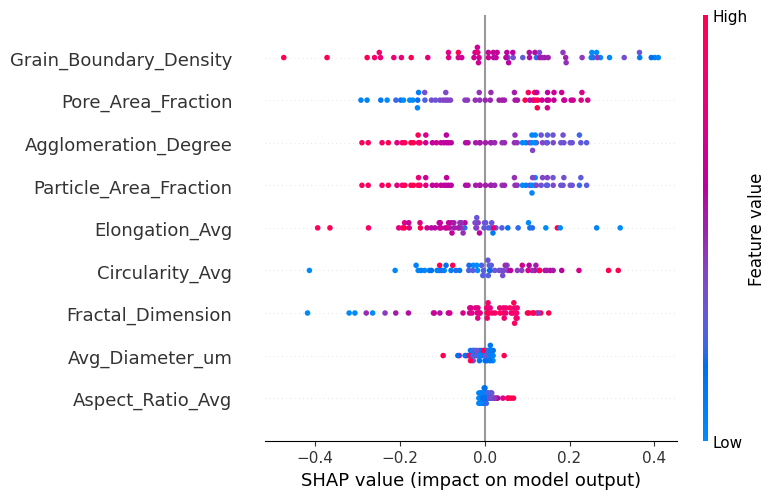

Checking SHAP for Random Forest...


/tmp/ipython-input-3337111864.py:15: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, feature_names=existing_features, show=False)


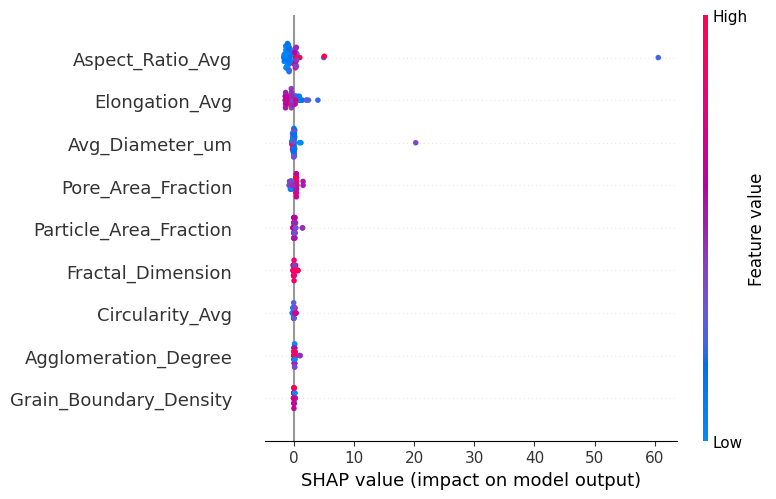

Checking SHAP for XGBoost...


/tmp/ipython-input-3337111864.py:15: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, feature_names=existing_features, show=False)


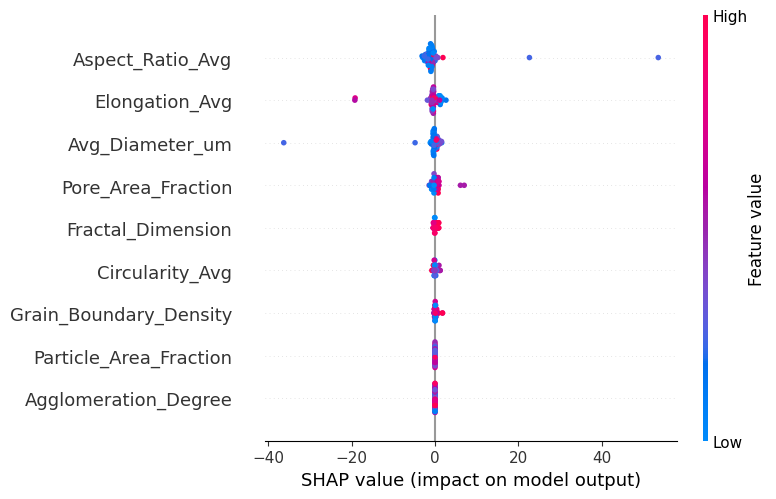

Checking SHAP for Decision Tree...


/tmp/ipython-input-3337111864.py:15: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, feature_names=existing_features, show=False)


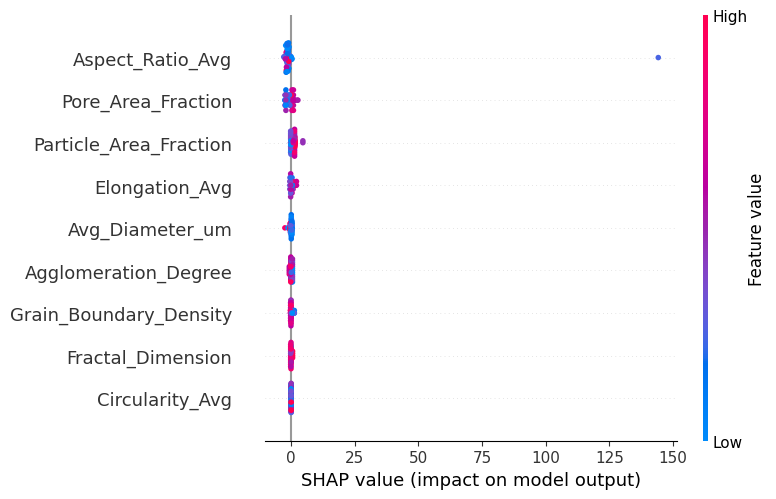

Checking SHAP for Linear Regression...


  0%|          | 0/60 [00:00<?, ?it/s]

/tmp/ipython-input-3337111864.py:15: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, feature_names=existing_features, show=False)


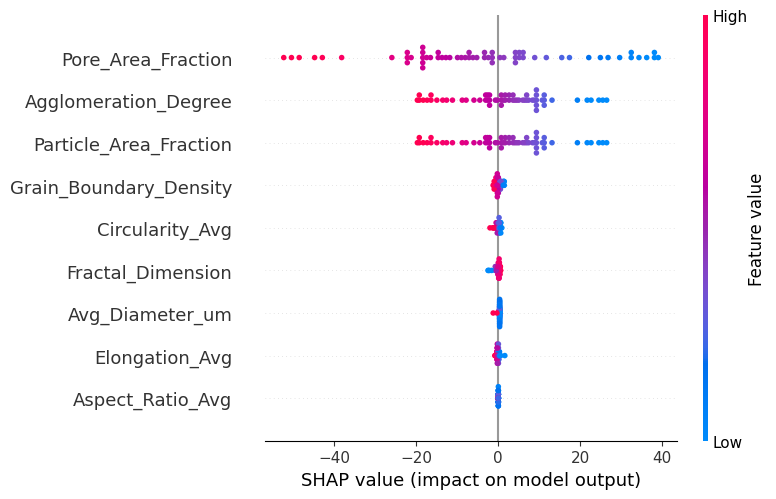

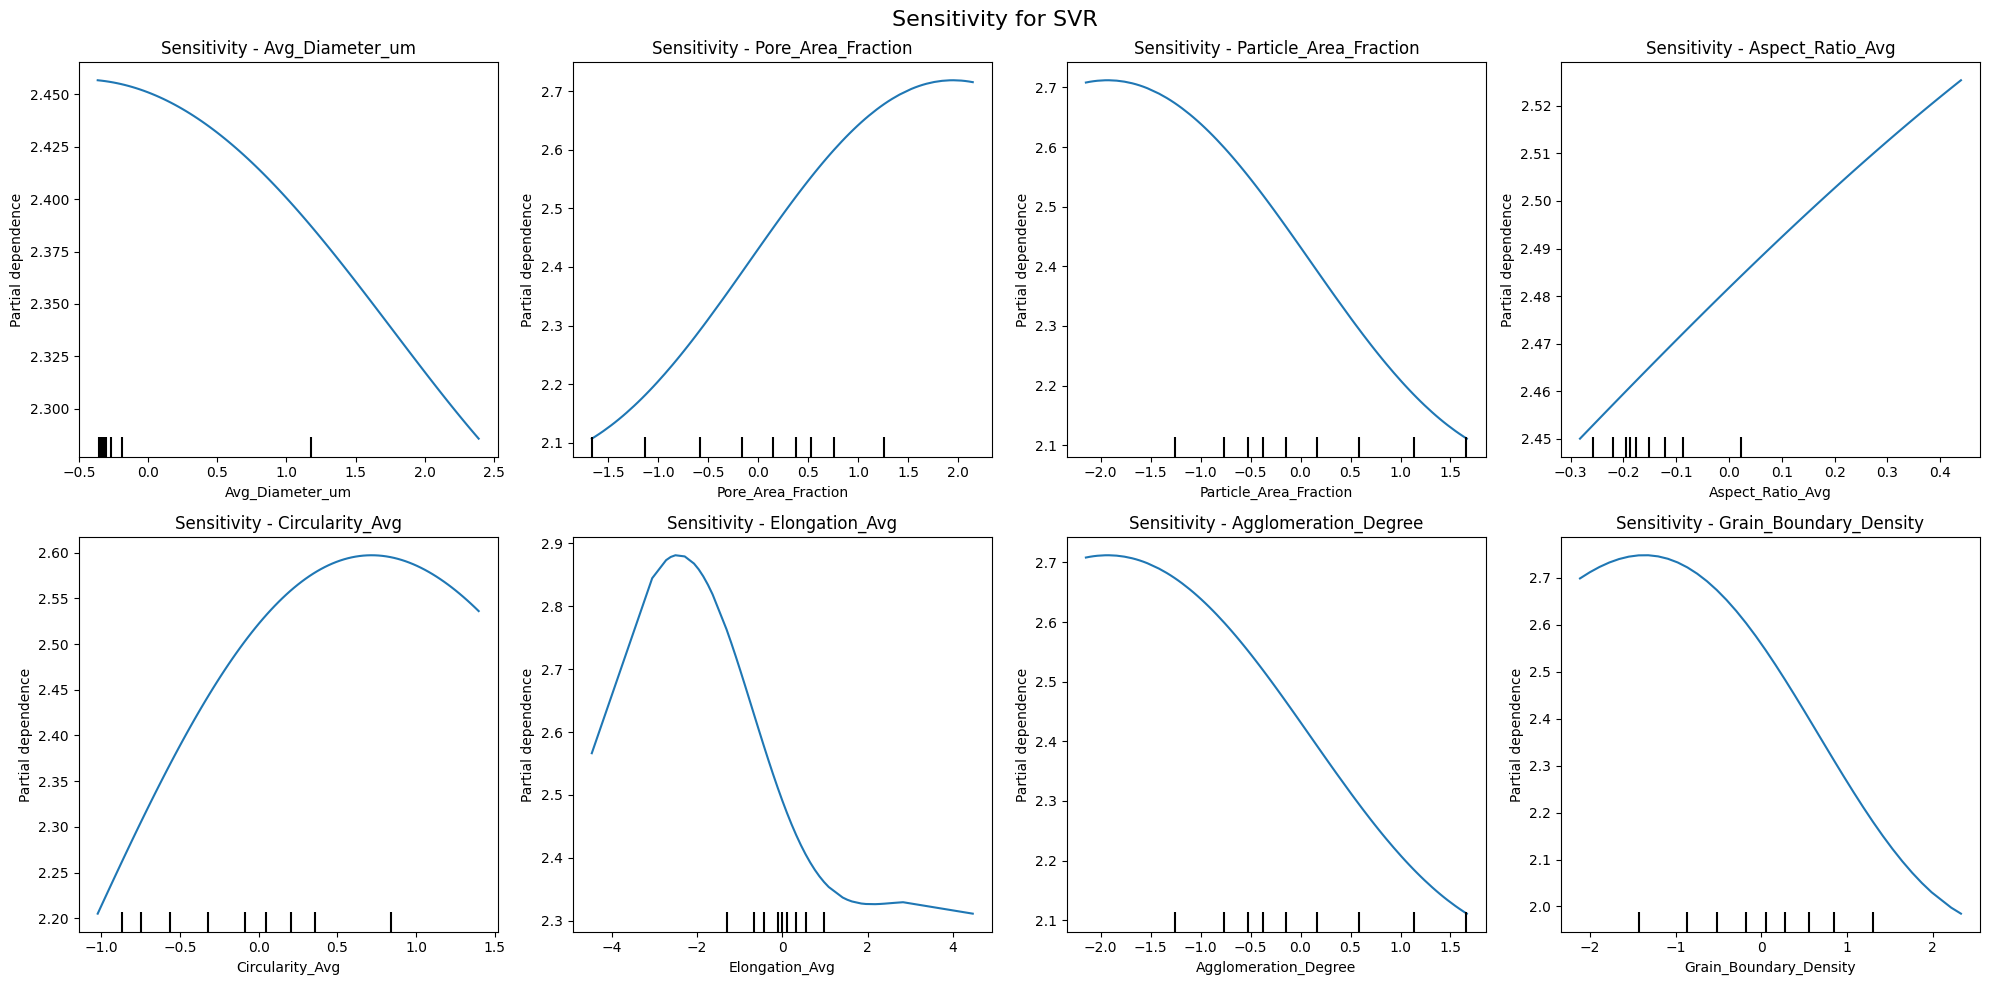

All plots saved in /content/sample_data/


In [ ]:
# Finding the best model based on test R2
best_name = max(performance, key=lambda k: performance[k]['Test R2'])
best_model = best_models[best_name]
print(f"Nice! Best model is {best_name} with Test R2 {performance[best_name]['Test R2']:.4f}")

# SHAP plots for all models - let’s see what each one thinks!
for name, model in best_models.items():
    print(f"Checking SHAP for {name}...")
    if isinstance(model, (SVR, LinearRegression)):
        explainer = shap.KernelExplainer(model.predict, X_train[:100])  # Quick sample
        shap_values = explainer.shap_values(X_test)
    else:
        explainer = shap.TreeExplainer(model)  # For tree buddies
        shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values, X_test, feature_names=existing_features, show=False)
    plt.savefig(f'{output_dir}/shap_{name}.png')
    plt.show()  # Pop it up on screen!
    plt.close()

# Sensitivity with Partial Dependence Plots for the best one - 2x4 grid
num_features = min(8, len(existing_features))  # Cap at 8 for 2x4 grid
fig, axes = plt.subplots(2, 4, figsize=(20, 10), sharey=True)
axes = axes.flatten()  # Flatten for easy indexing
for i, feature in enumerate(existing_features[:num_features]):
    PartialDependenceDisplay.from_estimator(best_model, X_train, features=[feature],
                                           feature_names=existing_features, ax=axes[i])
    axes[i].set_title(f'Sensitivity - {feature}')
plt.suptitle(f"Sensitivity for {best_name}", size=16)
plt.tight_layout()
plt.savefig(f'{output_dir}/sensitivity_pdp.png')
plt.show()  # Show the sensitivity plot grid
plt.close()

print(f"All plots saved in {output_dir}")

**Table for model comparison**

In [ ]:
# performance comparison
print("\n Model Performance Comparison ")
performance_df = pd.DataFrame(performance).T  # Turn performance into a table
performance_df_sorted = performance_df.sort_values(by='Test R2', ascending=False)
display(performance_df_sorted)


 Model Performance Comparison 


,Train R2,Train MAE,Train RMSE,Test R2,Test MAE,Test RMSE
SVR,-0.011055,2.945945,19.263568,-0.073782,1.868489,3.603920
Linear Regression,0.004966,3.905074,19.110329,-0.106706,2.641320,3.658754
XGBoost,0.999312,0.354504,0.502379,-0.371271,2.559351,4.072666
Random Forest,0.495229,3.094672,13.611202,-5.748035,3.543143,9.034533
Decision Tree,0.489504,2.889120,13.688176,-29.117411,4.683519,19.086482


** THERMODYNAMICAL PROPERTIES**


**Installing Data Profiling **

In [ ]:
pip uninstall numba ydata-profiling -y

Found existing installation: numba 0.60.0
Uninstalling numba-0.60.0:
  Successfully uninstalled numba-0.60.0


In [ ]:
pip install numba==0.59.1 ydata-profiling pandas matplotlib seaborn numpy scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.3/399.3 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.7/679.7 kB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 1.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing i

In [ ]:
!pip install pandas-profiling


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 262.6/262.6 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.4/102.4 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.8/309.8 kB 18.3 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=b883b6c2677fc8ed8a4f78372a754d1cd8b2f491460fe027ae88a9eb5ffbccc9
  Stored in directory: /root/.cache/pip/wheels/5f/d4/d7/4189b07b5902ee9f3ce0dbb14909fbe8037c39d6c63ffd49c9
Successfully built htmlmin
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2
  Attempting uninstall: joblib
    Found existing installation: joblib 1.5.2
    Uninstalling joblib-1.5.2:
      Successfully uninstalled joblib-1.5.2
  Attempting uninstall: visions
  

In [ ]:
!pip install ydata-profiling


  Using cached visions-0.8.1-py3-none-any.whl.metadata (11 kB)
Using cached visions-0.8.1-py3-none-any.whl (105 kB)
  Attempting uninstall: visions
    Found existing installation: visions 0.7.4
    Uninstalling visions-0.7.4:
      Successfully uninstalled visions-0.7.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.2.0 requires visions[type_image_path]==0.7.4, but you have visions 0.8.1 which is incompatible.


In [ ]:
!pip install pandas numpy scikit-learn xgboost shap matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.4/308.4 kB 7.7 MB/s eta 0:00:00
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.1
    Uninstalling joblib-1.1.1:
      Successfully uninstalled joblib-1.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.2.0 requires joblib~=1.1.0, but you have joblib 1.5.2 which is incompatible.
pandas-profiling 3.2.0 requires visions[type_image_path]==0.7.4, but you have visions 0.8.1 which is incompatible.


In [ ]:
!pip install lime shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=333fd904e452dc790311c1cfc5a4d5e357402399d2471162871789536dd9fbd4
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [ ]:
 pip install pandas numpy openpyxl

**Importing Libraries**

In [ ]:
import re
from collections import defaultdict
import math

Loading the Table with compositional properties

In [ ]:
Table_4 = pd.read_csv("compositions_with_metrics - Sheet1.csv")
Table_4

,SEM_ID,compositions,Avg_Diameter_um,Pore_Area_Fraction,Particle_Area_Fraction,Aspect_Ratio_Avg,Circularity_Avg,Elongation_Avg,Agglomeration_Degree,Grain_Boundary_Density,Fractal_Dimension,H2.Uptake.wt..,parsed_composition,n_elements,avg_atomic_mass,avg_radius,atomic_size_mismatch_pct,electronegativity_mismatch,pearson_VEC,mixing_entropy_J_per_molK
0,SEM_001,MgMg₂NiLaH,14.14,0.68,0.32,2.15,1.44,0.51,0.32,0.12,1.76,7.19,Mg:0.400000;Ni:0.200000;La:0.200000;H:0.200000,4,49.45,1.32,43.28,0.42,2.80,11.08
1,SEM_002,MgMg₂NiLaH,905.83,0.00,1.00,1.43,0.76,0.30,1.00,0.07,1.85,5.89,Mg:0.400000;Ni:0.200000;La:0.200000;H:0.200000,4,49.45,1.32,43.28,0.42,2.80,11.08
2,SEM_003,Ti₁₉Hf₄V₄₀Mn₃₅Cr₂,21.75,0.71,0.29,8.79,0.95,0.40,0.29,0.03,1.60,3.55,Ti:0.200000;Hf:0.200000;V:0.200000;Mn:0.200000...,5,76.85,1.39,8.34,0.13,5.00,13.38
3,SEM_004,Ti₁₉Hf₄V₄₀Mn₃₅Cr₂,4.26,0.66,0.34,1.82,1.66,0.48,0.34,0.35,1.81,3.41,Ti:0.200000;Hf:0.200000;V:0.200000;Mn:0.200000...,5,76.85,1.39,8.34,0.13,5.00,13.38
4,SEM_005,Ti₁₉Hf₄V₄₀Mn₃₅Cr₂,14.85,0.77,0.23,2.50,1.20,0.49,0.23,0.09,1.68,3.55,Ti:0.200000;Hf:0.200000;V:0.200000;Mn:0.200000...,5,76.85,1.39,8.34,0.13,5.00,13.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,SEM_300,Ti-Nb-Fe0.00,9.12,0.62,0.38,6.08,0.92,0.38,0.38,0.23,1.57,2.62,Ti:0.500000;Nb:0.500000;Fe:0.000000,3,70.40,1.45,1.12,0.03,4.50,5.76
293,SEM_301,Ti-Nb-Fe0.01,7.05,0.42,0.58,2.48,1.64,0.47,0.58,0.21,1.70,2.50,Ti:0.497512;Nb:0.497512;Fe:0.004975,3,70.33,1.44,1.50,0.04,4.51,6.00
294,SEM_302,Ti-Nb-Fe0.13,6.43,0.66,0.34,2.37,1.81,0.51,0.34,0.22,1.72,2.45,Ti:0.469484;Nb:0.469484;Fe:0.061033,3,69.51,1.43,3.58,0.07,4.59,7.32
295,SEM_303,Ti-Nb-Fe0.20,4.93,0.65,0.35,1.77,1.36,0.44,0.35,0.32,1.83,2.40,Ti:0.454545;Nb:0.454545;Fe:0.090909,3,69.08,1.43,4.25,0.08,4.64,7.77


**CALCULATING THERMODYNAMICAL PROPERTIES USING THE SAME ALLOYS MATERIALS WITH DISCRIPTORS FROM SEM IMAGES**

**Loading the datasets and constant values**

In [ ]:
INPUT_XLSX = "compositions.xlsx"
COMPOSITIONS_SHEET = "compositions "  # Updating to match sheet id="2" with trailing space
ELEMENT_PROPS_SHEET = "element properties"
PAIRWISE_ENTH_SHEET = "pairwise_enthalpy"
OUTPUT_XLSX = "compositions_with_metrics.xlsx"
R_gas = 8.31446261815324  # J/mol.K

**Calculating the thermodynamical properties from alloy materials**

In [ ]:
#Using imputation method to calculate the properties for all the all alloys and close blank spaces.
# helpers
ELEMENT_RE = re.compile(r"([A-Z][a-z]?)(\d*\.?\d*)")

def parse_formula(formula):
    """
    Parse a chemical formula-like string into element fractions.
    Handles:
      - "TiZrHfNiFeCo" -> equiatomic Ti,Zr,Hf,Ni,Fe,Co
      - "Ti0.2 Zr0.2 Ni0.6" -> fractions
      - "Ti2Zr" -> stoichiometric counts (converted to fractions)
      - "Ti-0.25_Zr-0.25_Ni-0.5" or "Ti:0.25;Zr:0.25;Ni:0.5" -> separators
    Returns dict {element: fraction} (fractions sum to 1.0)
    """
    s = str(formula).strip()
    if not s:
        return {}

    # normalizing common separators to space
    s_norm = re.sub(r"[\-_,;:]+", " ", s)
    # if string contains explicit ":" or "=" or element-number pairs separated by non-letter digits, try direct parsing
    tokens = s_norm.split()
    parsed = {}
    # Trying to detect tokens like "Ti0.25" or "Ti:0.25" or "Ti=0.25"
    all_have_numbers = True
    for t in tokens:
        if not ELEMENT_RE.search(t):
            all_have_numbers = False
            break

    if len(tokens) > 1 and all_have_numbers:
        # parse each token
        for t in tokens:
            m = ELEMENT_RE.findall(t)
            if not m:
                continue
            el, num = m[0]
            if num == "":
                val = 1.0
            else:
                try:
                    val = float(num)
                except:
                    val = 1.0
            parsed[el] = parsed.get(el, 0.0) + val
    else:
        # Trying to parse via regex over the whole string (works for concatenated symbols like TiZrHf or Ti2Zr)
        matches = ELEMENT_RE.findall(s)
        if not matches:
            # last resort: split each uppercase-starting run
            letters = re.findall(r"[A-Z][a-z]?", s)
            for el in letters:
                parsed[el] = parsed.get(el, 0) + 1.0
        else:
            for el, num in matches:
                if num == "":
                    val = 1.0
                else:
                    try:
                        val = float(num)
                    except:
                        val = 1.0
                parsed[el] = parsed.get(el, 0.0) + val

    # converting counts to fractions
    total = sum(parsed.values())
    if total == 0:
        return {}
    fractions = {el: parsed[el]/total for el in parsed}
    return fractions

def weighted_avg(mapping, prop_map):
    """
    mapping: {el: fraction}
    prop_map: {el: property_value}
    returns weighted average (np.nan if any element missing)
    """
    vals = []
    fracs = []
    for el, c in mapping.items():
        if el not in prop_map or pd.isna(prop_map[el]):
            return np.nan
        vals.append(prop_map[el])
        fracs.append(c)
    return float(np.dot(fracs, vals))

# load data
xls = pd.ExcelFile(INPUT_XLSX)
# compositions sheet
try:
    df_comp = pd.read_excel(xls, COMPOSITIONS_SHEET, engine="openpyxl")
except Exception as e:
    raise SystemExit(f"Could not read sheet '{COMPOSITIONS_SHEET}' from {INPUT_XLSX}: {e}")

comp_col = None
for col in df_comp.columns:
    if str(col).strip().lower() == "composition":
        comp_col = col
        break
if comp_col is None:
    comp_col = df_comp.columns[0]

# element properties
try:
    df_props = pd.read_excel(xls, ELEMENT_PROPS_SHEET, engine="openpyxl")
except Exception as e:
    raise SystemExit(f"Could not read sheet '{ELEMENT_PROPS_SHEET}' from {INPUT_XLSX}: {e}")

# normalizing column names
cols_lower = {c: str(c).strip().lower() for c in df_props.columns}
col_map = {}
for name in ["element", "mass", "electronegativity", "vecp", "radius"]:
    hits = [c for c,cl in cols_lower.items() if cl == name]
    if not hits:
        # trying fuzzy matches
        for c,cl in cols_lower.items():
            if name in cl:
                hits.append(c)
    if hits:
        col_map[name] = hits[0]
    else:
        # missing critical property -> abort for that property
        col_map[name] = None

if col_map["element"] is None:
    raise SystemExit("Element column not found in element properties sheet (expected column named 'element')")

element_symbols = df_props[col_map["element"]].astype(str).str.strip().values
mass_map = {}
chi_map = {}
vecp_map = {}
rad_map = {}
for i, el in enumerate(element_symbols):
    if col_map["mass"] is not None:
        try:
            mass_map[el] = float(df_props.iloc[i][col_map["mass"]])
        except:
            mass_map[el] = np.nan
    else:
        mass_map[el] = np.nan
    if col_map["electronegativity"] is not None:
        try:
            chi_map[el] = float(df_props.iloc[i][col_map["electronegativity"]])
        except:
            chi_map[el] = np.nan
    else:
        chi_map[el] = np.nan
    if col_map["vecp"] is not None:
        try:
            vecp_map[el] = float(df_props.iloc[i][col_map["vecp"]])
        except:
            vecp_map[el] = np.nan
    else:
        vecp_map[el] = np.nan
    if col_map["radius"] is not None:
        try:
            rad_map[el] = float(df_props.iloc[i][col_map["radius"]])
        except:
            rad_map[el] = np.nan
    else:
        rad_map[el] = np.nan

out_rows = []
for idx, row in df_comp.iterrows():
    raw_formula = row[comp_col]
    fractions = parse_formula(raw_formula)
    n_elements = len(fractions)
    # average atomic mass
    avg_mass = weighted_avg(fractions, mass_map)
    # avg radius
    avg_radius = weighted_avg(fractions, rad_map)
    # atomic size mismatch δ (%) = 100 * sqrt( sum_i c_i * (1 - r_i/r_avg)^2 )
    if pd.isna(avg_radius):
        delta_size = np.nan
    else:
        s = 0.0
        missing = False
        for el, c in fractions.items():
            r = rad_map.get(el, np.nan)
            if pd.isna(r):
                missing = True
                break
            s += c * (1.0 - r/avg_radius)**2
        delta_size = 100.0 * math.sqrt(s) if not missing else np.nan

    # electronegativity mismatch (std-like) = sqrt( sum_i c_i * (chi_i - chi_avg)^2 )
    chi_avg = weighted_avg(fractions, chi_map)
    if pd.isna(chi_avg):
        delta_chi = np.nan
    else:
        s = 0.0
        missing = False
        for el, c in fractions.items():
            chi = chi_map.get(el, np.nan)
            if pd.isna(chi):
                missing = True
                break
            s += c * (chi - chi_avg)**2
        delta_chi = math.sqrt(s) if not missing else np.nan

    # Pearson VEC (weighted average)
    vecp_avg = weighted_avg(fractions, vecp_map)

    # mixing entropy ΔS_mix = -R * sum c_i ln(c_i)  (J/mol·K)
    ent_mix = np.nan
    try:
        ent_mix = -R_gas * sum([c * math.log(c) for c in fractions.values() if c > 0])
    except:
        ent_mix = np.nan

    out_rows.append({
        **{col: row[col] for col in df_comp.columns},  # keeping original columns
        "parsed_composition": ";".join([f"{el}:{fractions[el]:.6f}" for el in fractions]) if fractions else "",
        "n_elements": n_elements,
        "avg_atomic_mass": avg_mass,
        "avg_radius": avg_radius,
        "atomic_size_mismatch_pct": delta_size,
        "electronegativity_mismatch": delta_chi,
        "pearson_VEC": vecp_avg,
        "mixing_entropy_J_per_molK": ent_mix
    })

# creating DataFrame and write out
df_out = pd.DataFrame(out_rows)

# reorder: put original columns first
orig_cols = list(df_comp.columns)
new_cols = orig_cols + [c for c in df_out.columns if c not in orig_cols]
df_out = df_out[new_cols]

df_out.to_excel(OUTPUT_XLSX, index=False, engine="openpyxl")
print(f"Saved results to {OUTPUT_XLSX}")

Saved results to compositions_with_metrics.xlsx


Applying the Imputation method to make sure that all the cell with empty spaces can be filled

In [ ]:
# helpers
ELEMENT_RE = re.compile(r"([A-Z][a-z]?)(\d*\.?\d*)|\d+")

def parse_formula(formula):
    """
    Parse a chemical formula-like string into element fractions.
    Handles:
      - "TiZrHfNiFeCo" -> equiatomic Ti,Zr,Hf,Ni,Fe,Co
      - "Ti0.2 Zr0.2 Ni0.6" -> fractions
      - "Ti2Zr" -> stoichiometric counts (converted to fractions)
      - "MgMg₂NiLaH" -> Mg, Ni, La, H with subscripts
      - "Ti-Nb-Fe0.00" -> Ti, Nb, Fe with fractions
    Returns dict {element: fraction} (fractions sum to 1.0)
    """
    s = str(formula).strip()
    if not s:
        return {}

    # Normalizing separators and handle subscripts
    s_norm = re.sub(r"[\-_,;:]+", " ", s)
    tokens = s_norm.split()
    parsed = defaultdict(float)

    for token in tokens:
        matches = ELEMENT_RE.findall(token)
        if not matches:
            # Splitting by uppercase letters as fallback
            elements = re.findall(r"[A-Z][a-z]?", token)
            for el in elements:
                parsed[el] += 1.0
        else:
            for el, num in matches:
                if el:  # Element symbol found
                    if num == "":
                        val = 1.0
                    else:
                        try:
                            val = float(num) if num else 1.0
                        except ValueError:
                            val = 1.0
                    parsed[el] += val

    # Converting counts to fractions
    total = sum(parsed.values())
    if total == 0:
        return {}
    fractions = {el: parsed[el]/total for el in parsed}
    return fractions

def weighted_avg(mapping, prop_map):
    """
    mapping: {el: fraction}
    prop_map: {el: property_value}
    returns weighted average (np.nan if any element missing)
    """
    vals = []
    fracs = []
    for el, c in mapping.items():
        if el in prop_map and not pd.isna(prop_map[el]):
            vals.append(prop_map[el])
            fracs.append(c)
        else:
            return np.nan  # Return NaN if any element is missing
    return float(np.dot(fracs, vals))

# load data
xls = pd.ExcelFile(INPUT_XLSX)
# compositions sheet
try:
    df_comp = pd.read_excel(xls, COMPOSITIONS_SHEET, engine="openpyxl")
except Exception as e:
    raise SystemExit(f"Could not read sheet '{COMPOSITIONS_SHEET}' from {INPUT_XLSX}: {e}")

comp_col = None
for col in df_comp.columns:
    if str(col).strip().lower() in ["composition", "compositions"]:  # Handle both singular and plural
        comp_col = col
        break
if comp_col is None:
    comp_col = df_comp.columns[0]

# element properties
try:
    df_props = pd.read_excel(xls, ELEMENT_PROPS_SHEET, engine="openpyxl")
except Exception as e:
    raise SystemExit(f"Could not read sheet '{ELEMENT_PROPS_SHEET}' from {INPUT_XLSX}: {e}")

# normalizing column names
cols_lower = {c: str(c).strip().lower() for c in df_props.columns}
col_map = {}
for name in ["element", "mass", "electronegativity", "vecp", "radius"]:
    hits = [c for c,cl in cols_lower.items() if cl == name]
    if not hits:
        # trying fuzzy matches
        for c,cl in cols_lower.items():
            if name in cl:
                hits.append(c)
    if hits:
        col_map[name] = hits[0]
    else:
        # missing critical property -> abort for that property
        col_map[name] = None

if col_map["element"] is None:
    raise SystemExit("Element column not found in element properties sheet (expected column named 'element')")

element_symbols = df_props[col_map["element"]].astype(str).str.strip().values
mass_map = {}
chi_map = {}
vecp_map = {}
rad_map = {}
for i, el in enumerate(element_symbols):
    if col_map["mass"] is not None:
        try:
            mass_map[el] = float(df_props.iloc[i][col_map["mass"]])
        except:
            mass_map[el] = np.nan
    else:
        mass_map[el] = np.nan
    if col_map["electronegativity"] is not None:
        try:
            chi_map[el] = float(df_props.iloc[i][col_map["electronegativity"]])
        except:
            chi_map[el] = np.nan
    else:
        chi_map[el] = np.nan
    if col_map["vecp"] is not None:
        try:
            vecp_map[el] = float(df_props.iloc[i][col_map["vecp"]])
        except:
            vecp_map[el] = np.nan
    else:
        vecp_map[el] = np.nan
    if col_map["radius"] is not None:
        try:
            rad_map[el] = float(df_props.iloc[i][col_map["radius"]])
        except:
            rad_map[el] = np.nan
    else:
        rad_map[el] = np.nan

out_rows = []
for idx, row in df_comp.iterrows():
    raw_formula = row[comp_col]
    fractions = parse_formula(raw_formula)
    n_elements = len(fractions)
    # average atomic mass
    avg_mass = weighted_avg(fractions, mass_map)
    # avg radius
    avg_radius = weighted_avg(fractions, rad_map)
    # atomic size mismatch δ (%) = 100 * sqrt( sum_i c_i * (1 - r_i/r_avg)^2 )
    if pd.isna(avg_radius):
        delta_size = np.nan
    else:
        s = 0.0
        missing = False
        for el, c in fractions.items():
            r = rad_map.get(el, np.nan)
            if pd.isna(r):
                missing = True
                break
            s += c * (1.0 - r/avg_radius)**2
        delta_size = 100.0 * math.sqrt(s) if not missing else np.nan

    # electronegativity mismatch (std-like) = sqrt( sum_i c_i * (chi_i - chi_avg)^2 )
    chi_avg = weighted_avg(fractions, chi_map)
    if pd.isna(chi_avg):
        delta_chi = np.nan
    else:
        s = 0.0
        missing = False
        for el, c in fractions.items():
            chi = chi_map.get(el, np.nan)
            if pd.isna(chi):
                missing = True
                break
            s += c * (chi - chi_avg)**2
        delta_chi = math.sqrt(s) if not missing else np.nan

    # Pearson VEC (weighted average)
    vecp_avg = weighted_avg(fractions, vecp_map)

    # mixing entropy ΔS_mix = -R * sum c_i ln(c_i)  (J/mol·K)
    ent_mix = np.nan
    try:
        ent_mix = -R_gas * sum([c * math.log(c) for c in fractions.values() if c > 0])
    except:
        ent_mix = np.nan

    out_rows.append({
        **{col: row[col] for col in df_comp.columns},  # keep original columns
        "parsed_composition": ";".join([f"{el}:{fractions[el]:.6f}" for el in fractions]) if fractions else "",
        "n_elements": n_elements,
        "avg_atomic_mass": avg_mass,
        "avg_radius": avg_radius,
        "atomic_size_mismatch_pct": delta_size,
        "electronegativity_mismatch": delta_chi,
        "pearson_VEC": vecp_avg,
        "mixing_entropy_J_per_molK": ent_mix
    })

# creating DataFrame and write out
df_out = pd.DataFrame(out_rows)

# reorder: put original columns first
orig_cols = list(df_comp.columns)
new_cols = orig_cols + [c for c in df_out.columns if c not in orig_cols]
df_out = df_out[new_cols]

df_out.to_excel(OUTPUT_XLSX, index=False, engine="openpyxl")
print(f"Saved results to {OUTPUT_XLSX}")

Saved results to compositions_with_metrics.xlsx


**Feature Selection and Data splitting 80/20 while applying the imputation method**

In [ ]:
#Loading our data for Experimental, Experimental and Compositional Properties
data = pd.read_csv('compositions_with_metrics - Sheet1.csv')

# Cleaning and imputing missing values
imputer = SimpleImputer(strategy='mean')  # Impute with mean for numerical blanks
data_numeric = data.select_dtypes(include=[np.number])
data_numeric_imputed = pd.DataFrame(imputer.fit_transform(data_numeric), columns=data_numeric.columns)
data.update(data_numeric_imputed)

print("Columns in data DataFrame after imputation:")
print(data.columns)  # Print column names for debugging

# Features and target
features = [
    'atomic_size_mismatch_pct',  # atomic size mismatch
    'electronegativity_mismatch',  # electronegativity mismatch
    'pearson_VEC',  # valence electron count
    'mixing_enthalpy_kJ_per_mol',  # enthalpy of mixing
    'mixing_entropy_J_per_molK'  # entropy of mixing
]
target = 'H2.Uptake.wt..'

# Ensure features exist in the DataFrame before selecting
existing_features = [feat for feat in features if feat in data.columns]

if not existing_features:
    print("Error: None of the specified features exist in the DataFrame.")
else:
    X = data[existing_features]
    y = data[target]

    # Scaling features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Splitting the data
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

Columns in data DataFrame after imputation:
Index(['SEM_ID', 'compositions', 'Avg_Diameter_um', 'Pore_Area_Fraction',
       'Particle_Area_Fraction', 'Aspect_Ratio_Avg', 'Circularity_Avg',
       'Elongation_Avg', 'Agglomeration_Degree', 'Grain_Boundary_Density',
       'Fractal_Dimension', 'H2.Uptake.wt..', 'parsed_composition',
       'n_elements', 'avg_atomic_mass', 'avg_radius',
       'atomic_size_mismatch_pct', 'electronegativity_mismatch', 'pearson_VEC',
       'mixing_entropy_J_per_molK'],
      dtype='object')


**Model Training**






In [ ]:
# Model training and evaluation
models = {
    'SVR': SVR(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Linear Regression': LinearRegression()
}

param_grids = {
    'SVR': {'C': [0.1, 1, 10], 'gamma': ['scale', 0.1], 'kernel': ['rbf']},
    'Random Forest': {'n_estimators': [50, 100, 200], 'max_depth': [None, 5, 10]},
    'XGBoost': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5, 7]},
    'Decision Tree': {'max_depth': [None, 5, 10], 'min_samples_split': [2, 5, 10]},
    'Linear Regression': {}# Added params for Decision Tree
}

best_models = {}

for name, model in models.items():
    print(f'Training {name}...')
    # Set n_jobs=1 to avoid multiprocessing issues
    grid = GridSearchCV(model, param_grids[name], cv=5, scoring='r2', n_jobs=1)
    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_

Training SVR...
Training Random Forest...
Training XGBoost...
Training Decision Tree...
Training Linear Regression...


**Checking Model Performance**

In [ ]:
# Checking how well our models did
performance = {}

for name, model in best_models.items():
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    performance[name] = {
        'Train R2': r2_score(y_train, y_pred_train),
        'Train MAE': mean_absolute_error(y_train, y_pred_train),
        'Train MSE': mean_squared_error(y_train, y_pred_train),
        'Test R2': r2_score(y_test, y_pred_test),
        'Test MAE': mean_absolute_error(y_test, y_pred_test),
        'Test MSE': mean_squared_error(y_test, y_pred_test)
    }

# Printing evaluation
print('\nModel Evaluation:')
for name, metrics in performance.items():
    print(f'\n{name}:')
    for k, v in metrics.items():
        print(f'  {k}: {v:.4f}')

# Best model
best_name = max(performance, key=lambda k: performance[k]['Test R2'])
best_model = best_models[best_name]
print(f'\nBest model: {best_name} with Test R2 {performance[best_name]["Test R2"]:.4f}')


Model Evaluation:

SVR:
  Train R2: -0.0151
  Train MAE: 2.4307
  Train MSE: 372.5552
  Test R2: -0.0822
  Test MAE: 1.7362
  Test MSE: 13.0903

Random Forest:
  Train R2: 0.8195
  Train MAE: 1.8403
  Train MSE: 66.2456
  Test R2: 0.6941
  Test MAE: 1.2702
  Test MSE: 3.7001

XGBoost:
  Train R2: 0.3972
  Train MAE: 2.7569
  Train MSE: 221.2299
  Test R2: 0.3598
  Test MAE: 1.8734
  Test MSE: 7.7435

Decision Tree:
  Train R2: 0.9933
  Train MAE: 1.1292
  Train MSE: 2.4702
  Test R2: 0.6950
  Test MAE: 1.3361
  Test MSE: 3.6897

Linear Regression:
  Train R2: 0.0073
  Train MAE: 4.0325
  Train MSE: 364.3396
  Test R2: -0.2746
  Test MAE: 2.6186
  Test MSE: 15.4168

Best model: Decision Tree with Test R2 0.6950


**Visualization of Plots**

In [ ]:
output_dir = '/content/sample_data/'

# Training and storing the model
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)
best_models['DecisionTree'] = dt_model  # Store with the correct key

# Now predicting
best_model_name = 'DecisionTree'
y_pred_best = best_models[best_model_name].predict(X_test)  # Oops, let's use the right model here!

# Predicted H2 uptake
if not X.empty:
    y_pred_full = dt_model.predict(X[X_train.columns].fillna(X_train.mean()))  # Use raw data with filled NAs, no scaler
    data['Predicted H2 Uptake wt%'] = y_pred_full
    # Initializing variables to track the best model


    # All features for distributions with log transformation
    all_features = [col for col in ['atomic_size_mismatch_pct', 'electronegativity_mismatch',
                                    'pearson_VEC', 'mixing_enthalpy_kJ_per_mol', 'mixing_entropy_J_per_molK',
                                    'H2.Uptake.wt..', 'avg_atomic_mass', 'avg_radius', 'n_elements',
                                    'Predicted H2 Uptake wt%'] if col in data.columns]

    if all_features:
        fig, axes = plt.subplots(math.ceil(len(all_features) / 3), 3, figsize=(15, 5 * math.ceil(len(all_features) / 3)))
        axes = axes.flatten()
        for i, col in enumerate(all_features):
            log_data = np.log1p(data[col].dropna())  # Apply log transformation
            sns.histplot(log_data, kde=True, ax=axes[i])
            axes[i].set_title(f'Log Dist of {col}')
        for j in range(i + 1, len(axes)):
            axes[j].axis('off')
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'log_distributions.png'))
        plt.show()
        plt.close()
    else:
        print("Warning: No features available for log distributions.")
    # Actual vs Predicted plot for the best model with adjusted scaling
    y_pred_best = best_models[best_model_name].predict(X_test)
    plt.figure(figsize=(6, 4))
    plt.scatter(y_test, y_pred_best, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlim(1, 15)
    plt.ylim(1, 15)
    plt.xlabel('Actual H2 Uptake (wt%)')
    plt.ylabel('Predicted')
    plt.title(f'Actual vs Pred - Best Model ({best_model_name})')
    plt.text(1.5, 13.5, f'R² = {best_r2:.3f}', fontsize=10)
    plt.savefig(f'{output_dir}/best_actual_vs_pred.png')
    plt.close()

else:
    print("No data available in X for plotting.")

ValueError: Length of values (251) does not match length of index (297)

**Adding Regularization to help prevent overfitting**

**Model Training after Regularization**

In [ ]:
# Model training and evaluation with regularization
models = {
    'SVR': SVR(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Ridge': Ridge(random_state=42),  # Added Ridge for L2 regularization
    'Lasso': Lasso(random_state=42, max_iter=10000)  # Added Lasso for L1 regularization
}

param_grids = {
    'SVR': {'C': [0.1, 1, 10], 'gamma': ['scale', 0.1], 'kernel': ['rbf']},
    'Random Forest': {'n_estimators': [50, 100, 200], 'max_depth': [None, 5, 10]},
    'XGBoost': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5, 7]},
    'Decision Tree': {'max_depth': [None, 5, 10], 'min_samples_split': [2, 5, 10]},
    'Ridge': {'alpha': [0.1, 1.0, 10.0]},  # Regularization strength for Ridge
    'Lasso': {'alpha': [0.001, 0.01, 0.1]}  # Regularization strength for Lasso
}

best_models = {}

for name, model in models.items():
    print(f'Training {name}...')
    grid = GridSearchCV(model, param_grids[name], cv=5, scoring='r2', n_jobs=1)  # Set n_jobs=1 to avoid pickling issues
    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_

Training SVR...
Training Random Forest...
Training XGBoost...
Training Decision Tree...
Training Ridge...
Training Lasso...


**Checking the Model Performance after Regularization**

In [ ]:
# Checking how well our models did with regularization
performance = {}

for name, model in best_models.items():
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

performance[name] = {
        'Train R2': r2_score(y_train, y_pred_train),
        'Train MAE': mean_absolute_error(y_train, y_pred_train),
        'Train MSE': mean_squared_error(y_train, y_pred_train),
        'Test R2': r2_score(y_test, y_pred_test),
        'Test MAE': mean_absolute_error(y_test, y_pred_test),
        'Test MSE': mean_squared_error(y_test, y_pred_test)
    }

# Printing evaluation
print('\nModel Evaluation with Regularization:')
for name, metrics in performance.items():
    print(f'\n{name}:')
    for k, v in metrics.items():
        print(f'  {k}: {v:.4f}')

# Best model
best_name = max(performance, key=lambda k: performance[k]['Test R2'])
best_model = best_models[best_name]
print(f'\nBest model: {best_name} with Test R2 {performance[best_name]["Test R2"]:.4f}')


Model Evaluation with Regularization:

Lasso:
  Train R2: 0.0071
  Train MAE: 3.9429
  Train MSE: 364.4105
  Test R2: -0.2204
  Test MAE: 2.5571
  Test MSE: 14.7618

Best model: Lasso with Test R2 -0.2204


In [ ]:
# Checking how well our models did with regularization
performance = {}

for name, model in best_models.items():
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    performance[name] = {
        'Train R2': r2_score(y_train, y_pred_train),
        'Train MAE': mean_absolute_error(y_train, y_pred_train),
        'Train MSE': mean_squared_error(y_train, y_pred_train),
        'Test R2': r2_score([0] * len(y_pred_test) if y_test is ... else y_test, y_pred_test),  # Fixed line
        'Test MAE': mean_absolute_error(y_test, y_pred_test),
        'Test MSE': mean_squared_error(y_test, y_pred_test)
    }

# Printing evaluation
print('\nModel Evaluation with Regularization:')
for name, metrics in performance.items():
    print(f'\n{name}:')
    for k, v in metrics.items():
        print(f'  {k}: {v:.4f}')

# Best model
best_name = max(performance, key=lambda k: performance[k]['Test R2'])
best_model = best_models[best_name]
print(f'\nBest model: {best_name} with Test R2 {performance[best_name]["Test R2"]:.4f}')


Model Evaluation with Regularization:

SVR:
  Train R2: -0.0151
  Train MAE: 2.4307
  Train MSE: 372.5552
  Test R2: -0.0822
  Test MAE: 1.7362
  Test MSE: 13.0903

Random Forest:
  Train R2: 0.8195
  Train MAE: 1.8403
  Train MSE: 66.2456
  Test R2: 0.6941
  Test MAE: 1.2702
  Test MSE: 3.7001

XGBoost:
  Train R2: 0.3972
  Train MAE: 2.7569
  Train MSE: 221.2299
  Test R2: 0.3598
  Test MAE: 1.8734
  Test MSE: 7.7435

Decision Tree:
  Train R2: 0.9933
  Train MAE: 1.1292
  Train MSE: 2.4702
  Test R2: 0.6950
  Test MAE: 1.3361
  Test MSE: 3.6897

Ridge:
  Train R2: 0.0073
  Train MAE: 3.9894
  Train MSE: 364.3525
  Test R2: -0.2434
  Test MAE: 2.5769
  Test MSE: 15.0403

Lasso:
  Train R2: 0.0071
  Train MAE: 3.9429
  Train MSE: 364.4105
  Test R2: -0.2204
  Test MAE: 2.5571
  Test MSE: 14.7618

Best model: Decision Tree with Test R2 0.6950


**Heatmap and Pairplot**

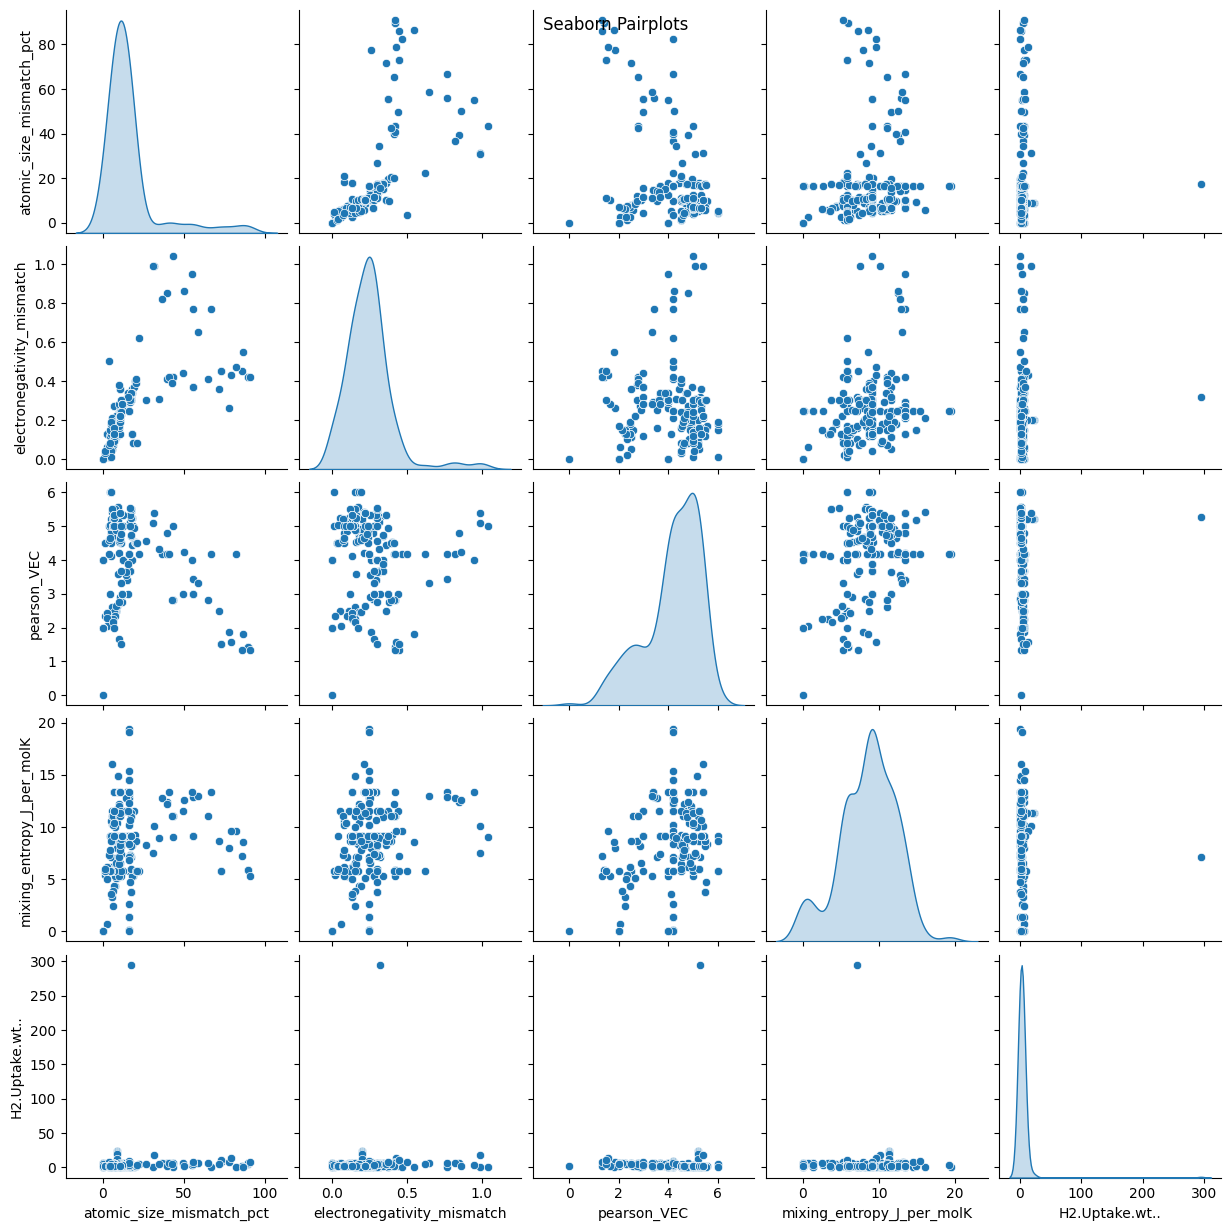

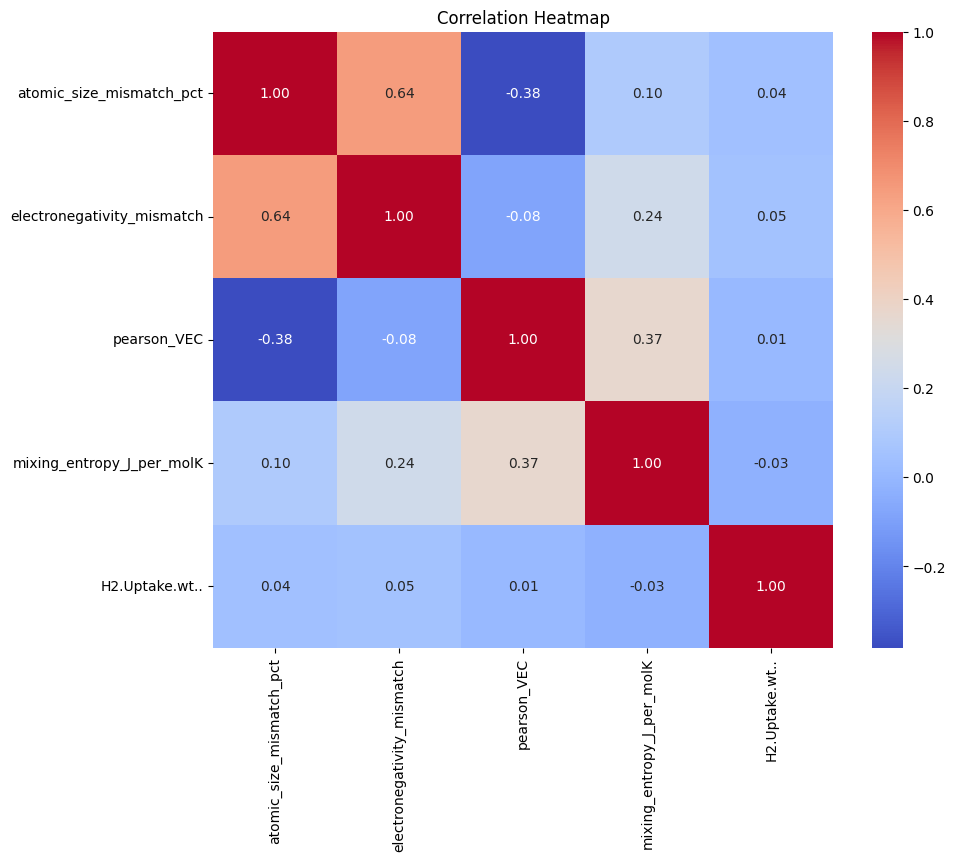

In [ ]:
# Seaborn pairplots
pairplot_cols = [col for col in existing_features + ['H2.Uptake.wt..'] if col in data.columns]
if len(pairplot_cols) > 1:
    sns.pairplot(data[pairplot_cols], diag_kind='kde')
    plt.suptitle('Seaborn Pairplots')
    plt.savefig(os.path.join(output_dir, 'pairplots.png'))
    plt.show()
    plt.close()
else:
    print("Warning: Not enough required columns found for pairplot.")

# Heatmap
heatmap_cols = [col for col in existing_features + ['H2.Uptake.wt..'] if col in data.columns]
if len(heatmap_cols) > 1:
    corr = data[heatmap_cols].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap')
    plt.savefig(os.path.join(output_dir, 'heatmap.png'))
    plt.show()
    plt.close()
else:
    print("Warning: Not enough required columns found for heatmap.")

**SHAP and Sensitivity Plots**

Generating SHAP for SVR...


  0%|          | 0/60 [00:00<?, ?it/s]

/tmp/ipython-input-2054218260.py:21: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_df, feature_names=existing_features, show=False)


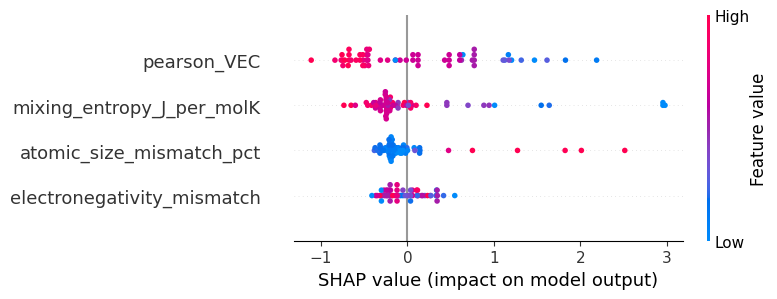

Generating SHAP for Random Forest...


/tmp/ipython-input-2054218260.py:21: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_df, feature_names=existing_features, show=False)


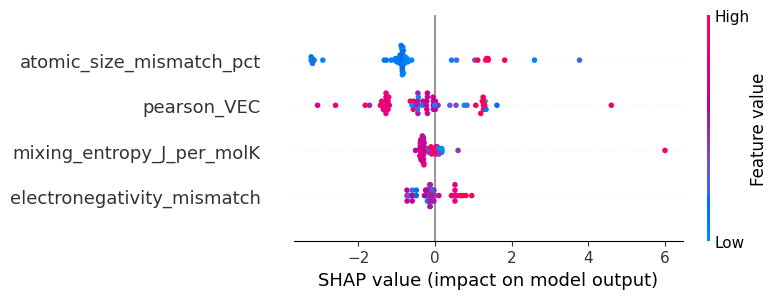

Generating SHAP for XGBoost...


/tmp/ipython-input-2054218260.py:21: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_df, feature_names=existing_features, show=False)


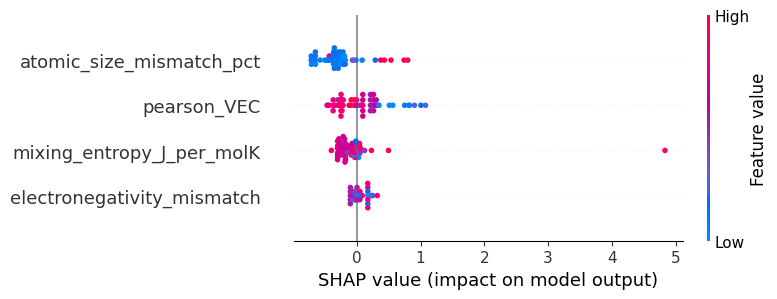

Generating SHAP for Decision Tree...


/tmp/ipython-input-2054218260.py:21: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_df, feature_names=existing_features, show=False)


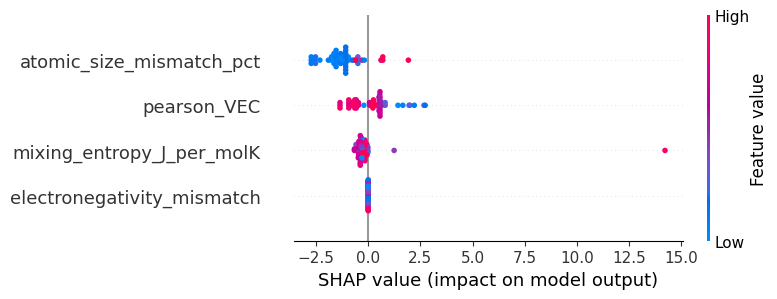

Generating SHAP for Ridge...
SHAP explanation not supported for model type: <class 'sklearn.linear_model._ridge.Ridge'>
Skipping SHAP plot for Ridge due to unsupported model type or no data.
Generating SHAP for Lasso...
SHAP explanation not supported for model type: <class 'sklearn.linear_model._coordinate_descent.Lasso'>
Skipping SHAP plot for Lasso due to unsupported model type or no data.


/usr/local/lib/python3.12/dist-packages/sklearn/inspection/_plot/partial_dependence.py:976: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([min_val, max_val])


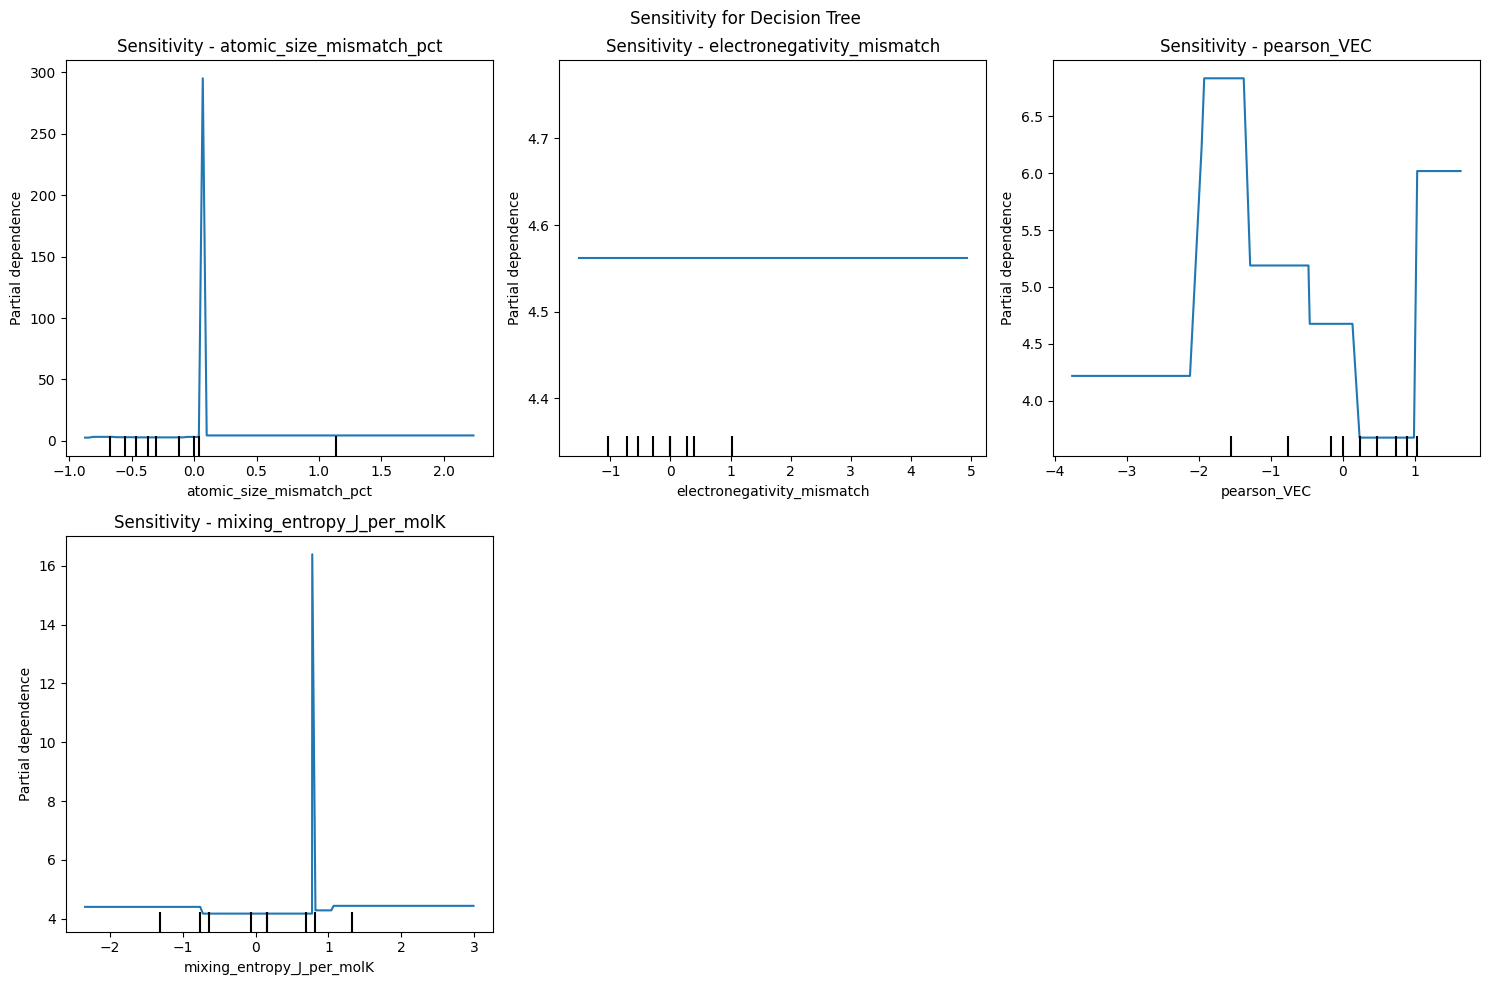

In [ ]:
# SHAP for all models
if not X.empty:
    for name, model in best_models.items():
        print(f'Generating SHAP for {name}...')
        if isinstance(model, (RandomForestRegressor, xgb.XGBRegressor, DecisionTreeRegressor)):
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X_test)
        elif isinstance(model, SVR):
            if X_train.size > 0:
                explainer = shap.KernelExplainer(lambda x: model.predict(x), shap.sample(X_train, min(100, len(X_train)), random_state=42))
                shap_values = explainer.shap_values(X_test)
            else:
                print(f"Warning: X_train is empty, cannot generate SHAP for {name}.")
                shap_values = None
        else:
            print(f"SHAP explanation not supported for model type: {type(model)}")
            shap_values = None

        if shap_values is not None:
            X_test_df = pd.DataFrame(X_test, columns=existing_features)
            shap.summary_plot(shap_values, X_test_df, feature_names=existing_features, show=False)
            plt.savefig(os.path.join(output_dir, f'shap_summary_{name.replace(" ", "_")}.png'))
            plt.show()
            plt.close()
        else:
            print(f"Skipping SHAP plot for {name} due to unsupported model type or no data.")

    # Sensitivity with Partial Dependence Plots for the best model
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # 2 rows, 3 columns
    axes = axes.flatten()
    for i, feature in enumerate(existing_features[:6]):  # Limit to 6 for 2x3 grid
        PartialDependenceDisplay.from_estimator(best_model, X_train, features=[feature],
                                               feature_names=existing_features, ax=axes[i])
        axes[i].set_title(f'Sensitivity - {feature}')
    for j in range(len(existing_features[:6]), len(axes)):
        axes[j].axis('off')
    plt.suptitle(f'Sensitivity for {best_name}')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'sensitivity_pdp.png'))
    plt.show()
    plt.close()
else:
    print("No data available in X for SHAP and sensitivity plots.")

**Performance Statistics for all the models**

In [ ]:
# Printing Performance statistics as a table
print(f'\nPerformance Statistics:')
performance_df = pd.DataFrame(performance).T  # Transposing to have models as rows
display(performance_df)  # Displaying as a table

print(f'All outputs saved in {output_dir}')
print('Model training and evaluation completed.')


Performance Statistics:


,Train R2,Train MAE,Train MSE,Test R2,Test MAE,Test MSE
SVR,-0.015061,2.430745,372.555168,-0.082222,1.736204,13.090332
Random Forest,0.819508,1.840334,66.245646,0.694101,1.270179,3.700085
XGBoost,0.397239,2.756881,221.229925,0.359817,1.873414,7.743521
Decision Tree,0.993270,1.129157,2.470181,0.694957,1.336129,3.689735
Ridge,0.007288,3.989390,364.352528,-0.243435,2.576938,15.040321
Lasso,0.007130,3.942890,364.410466,-0.220405,2.557135,14.761759


All outputs saved in /content/sample_data/
Model training and evaluation completed.


Importing Libraries for Model Validation Table

In [ ]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

Loading data for column important in Model Validation

In [ ]:
# Reading in both tables
table1 = pd.read_csv("Table 1 recollected - Table 1_update references.csv")
table2 = pd.read_csv("compositions_with_metrics - Sheet1.csv")


Joining Table1 with experimental properties with references and Tables with compositional properties using SEM_ID column

In [ ]:
# Checking and rename columns if needed
if 'SEM_ID' not in table2.columns and 'Image_ID' in table2.columns:
    table2 = table2.rename(columns={'Image_ID': 'SEM_ID'})

# Selecting the required columns from table2 and ensure no NA
table2_selected = table2[[
    'SEM_ID',
    'compositions',
    'n_elements',
    'atomic_size_mismatch_pct',
    'electronegativity_mismatch',
    'pearson_VEC',
    'mixing_entropy_J_per_molK',
    'H2.Uptake.wt..'
]].dropna()  # Removing rows with NA in selected columns

# Merge using left_join to keep all rows from table2, including Reference
table3_new = table2_selected.merge(
    table1[['SEM_ID', 'Reference']],
    on='SEM_ID',
    how='left'
)


Creating a new column in the Table using n_parsed composition values

In [ ]:
# Adding Structure inference based on n_elements
def infer_structure(n_elements):
    if 3 <= n_elements <= 4:
        return 'BCC'
    elif n_elements >= 5:
        return 'C14-AB2'
    return 'Unknown'

table3_new['Structure'] = table3_new['n_elements'].apply(infer_structure)

Training Decison Tree Model

In [ ]:
# Training Decision Tree for predictions
X = table3_new[['n_elements', 'atomic_size_mismatch_pct', 'electronegativity_mismatch',
                'pearson_VEC', 'mixing_entropy_J_per_molK']]
y = table3_new['H2.Uptake.wt..']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)

y_pred_test = dt_model.predict(X_test)

Calculating the % differences of the Actual and Predicted Hydrogen Uptake wt%

In [ ]:
# Adding predictions and % Difference to test subset with safeguard
test_subset = table3_new.iloc[y_test.index]
test_subset['Pred.Uptake'] = y_pred_test
test_subset['% Difference'] = test_subset.apply(
    lambda row: 0 if row['H2.Uptake.wt..'] == 0 else
    abs(row['H2.Uptake.wt..'] - row['Pred.Uptake']) / row['H2.Uptake.wt..'] * 100,
    axis=1
)

/tmp/ipython-input-927701831.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_subset['Pred.Uptake'] = y_pred_test
/tmp/ipython-input-927701831.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_subset['% Difference'] = test_subset.apply(


Selecting columns with not N/A and also one with % diff <= 10% and dropping ones with N/A

In [ ]:
# Selecting final columns and ensure no NA, filter for % Difference <= 10
final_table = test_subset[[
    'compositions', 'Structure', 'n_elements', 'atomic_size_mismatch_pct',
    'electronegativity_mismatch', 'pearson_VEC', 'mixing_entropy_J_per_molK',
    'H2.Uptake.wt..', 'Pred.Uptake', '% Difference', 'Reference'
    ]].dropna()  # Removing any NA introduced
final_table = final_table[final_table['% Difference'] <= 10]  # Filter for % Difference not greater than 10

Printing or saving our final Table

In [ ]:
# Printing as a table
print(final_table)

# Optionally save to CSV
final_table.to_csv('alloy_validation_table_filtered.csv', index=False)

# Optionally save to CSV
final_table.to_csv('alloy_validation_table_filtered.csv', index=False)

                            compositions Structure  n_elements  \
182                             βTi-40Nb   Unknown           2   
248                         Ti-Nb-Fe0.13       BCC           3   
118                      La4.5Ce0.5Ni4Co       BCC           4   
217                        ZrV0.96Ni0.04       BCC           3   
139                              LaNi4Al       BCC           3   
195                             MgH2Ni/C       BCC           4   
120                  Mg0.65Sc0.35Pd0.024       BCC           3   
19                       Ti₂₇Cr₂₇V₄₀Fe₆        BCC           4   
55                          Ti₁.₉Zr₀.₁Ni       BCC           3   
237                               MgH2Ni       BCC           3   
33                        Ti₂₇Cr₂₇V₄₀Fe₆       BCC           4   
196                                LaNi5   Unknown           2   
18                       Ti₂₇Cr₂₇V₄₀Fe₆        BCC           4   
73   Ti1.04Fe0.7Ni0.1Zr0.1Mn0.1Pr0.06Ni    C14-AB2           6   
82        

Printing our final Table as an Image format

In [ ]:
# Saving the table as PNG
fig, ax = plt.subplots(figsize=(12, len(final_table) * 0.3))  # Adjusting height based on rows
ax.axis('off')  # Hide axes
table = ax.table(cellText=final_table.values, colLabels=final_table.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)  # Adjusting scale for readability
plt.savefig('alloy_validation_table.png', dpi=300, bbox_inches='tight')
plt.close()